# This notebook:
### plots beaching probability for the entire ocean with contours with temporal ENSO state contrast FOR data 6 months to beach, 1 year to beach

In [39]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

In [213]:
# dependencies
import pandas as pd
import scipy.interpolate as sci_int
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sci_stats
import cartopy.crs as ccrs
import geopandas as gpd

import matplotlib.colors as mcolors
import cartopy.feature as cfeature
plt.rcParams.update({'font.size': 18})

plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.labelsize'] = 22

In [41]:
# import undrogued ENSO data
beach = pd.read_csv('ENSO_beach.csv')
unbeach = pd.read_csv('ENSO_unbeach.csv')

In [153]:
# define universal resolution of plots:
n_lons_u, n_lats_u = 90,45

### we're going to use similar steps as the 'ENSO_controued_beach_probabailities.ipynb' , but first select a subset of the data temporally and plot a global probability of beaching

In [154]:
# grab 6 months to beach
seconds_in_6_month = 60 * 60 * 24 * 30.42 * 6
beach_6 = beach[beach['time_to_beach'] <= seconds_in_6_month]

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


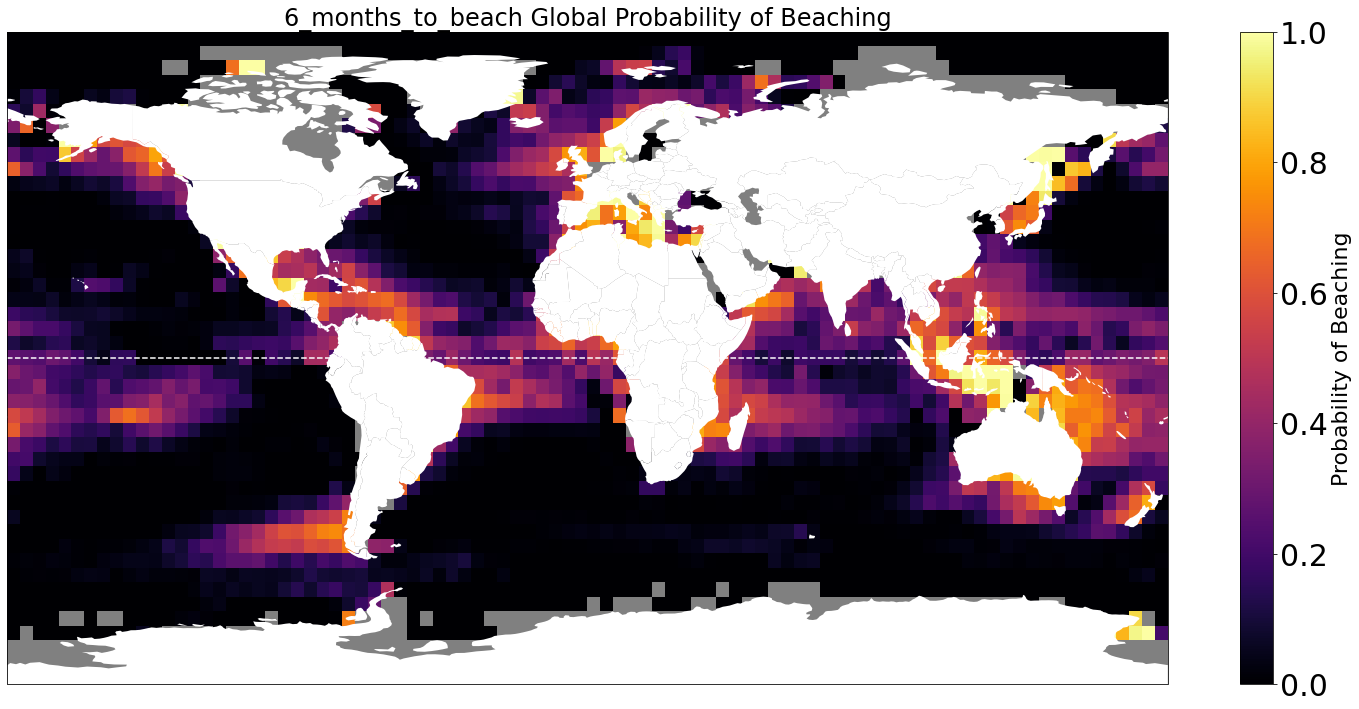

In [155]:
# this code comes from 'probability of beaching.ipynb'

# define probability of beaching function
def probability_of_beaching(beached_count, unbeached_count):
    probability = beached_count / (beached_count + unbeached_count)
    return probability

# get beached lats and lons
beach_undrogued_lats = np.array(beach_6['lat'])
beach_undrogued_longs = np.array(beach_6['lon'])

# get unbeached lats and lons
unbeach_undrogued_lats = np.array(unbeach['lat'])
unbeach_undrogued_longs = np.array(unbeach['lon'])

# concatenate them together into single lat/lon lists
lats = np.concatenate((beach_undrogued_lats, unbeach_undrogued_lats))
longs = np.concatenate((beach_undrogued_longs, unbeach_undrogued_longs))

# let's use sci_stats.binned_statistic_2d to bin by lat/lon and count

# beached
n_lons, n_lats = n_lons_u, n_lats_u # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

beach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    beach_undrogued_longs,beach_undrogued_lats,values=beach_6['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

# unbeached
n_lons, n_lats = n_lons_u, n_lats_u # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

unbeach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    unbeach_undrogued_longs,unbeach_undrogued_lats,values=unbeach['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

probability_6_months = probability_of_beaching(beach_undrogued_stat, unbeach_undrogued_stat)


# Given location, probability of beaching
# Undrogued

fig = plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# colormap
cmap = plt.cm.get_cmap("inferno").copy()
cmap.set_bad('grey')

# plot hist on world
plt.imshow(probability_6_months.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap)

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(label='Probability of Beaching')
ax.set_aspect('auto')
plt.title('6_months_to_beach Global Probability of Beaching')
plt.axhline(y=0, color='white', linestyle='--', label='Equator')

In [156]:
# now working from the end of 'ENSO_classification.ipynb'
# now, we consider the relative amount of time each drifter trajectory spends in the temporal el nino or la nina regimes. 
# If a drifter trajectory spends more than 80% of time in one regime or the other, we classify that drifter trajectory as an el nino or 
# la nina drifter trajectory, thus grouping our trajectories by temporal ENSO regime. If a drifter trajectory spends less than 80% of time 
# in either regime, then we classify that drifter trajectory as a 'mixed_ENSO' drifter trajectory

In [157]:
def classify_ENSO_trajectories(df, percent_parameter):
    # Group by id and ENSO state to calculate the percent in each group
    value_counts = df.groupby('id')['ENSO'].value_counts(normalize=True) * 100

    # initialize lists
    el_nino_traj = []
    la_nina_traj = []
    mixed_ENSO_traj = []

    # iterate through unique ids
    for ID in value_counts.index.get_level_values(0).unique():
        
        # get percent in el nino and la nina
        percent_el_nino = value_counts.get((ID, 'el nino'), 0)
        percent_la_nina = value_counts.get((ID, 'la nina'), 0)

        # classify id based on percentages
        if percent_el_nino >= percent_parameter:
            el_nino_traj.append(ID)
        elif percent_la_nina >= percent_parameter:
            la_nina_traj.append(ID)
        else:
            mixed_ENSO_traj.append(ID)

    return el_nino_traj, la_nina_traj, mixed_ENSO_traj


# We define a function to get the coordinates of a calculated contour shape as an array
def coords_contour(contour):
    contour_lons = []
    contour_lats = []

    for contour_test in contour.collections:
        for path in contour_test.get_paths():
            vertices = path.vertices
            contour_lons.extend(vertices[:, 0])
            contour_lats.extend(vertices[:, 1])

    contour_lons = np.array(contour_lons)
    contour_lats = np.array(contour_lats)
    return [contour_lons, contour_lats]

In [158]:
# 95 percent seems good
percent_parameter = 95

# beach
el_nino_traj_beach, la_nina_traj_beach, mixed_ENSO_traj_beach = classify_ENSO_trajectories(beach_6, percent_parameter)

# unbeach
el_nino_traj_unbeach, la_nina_traj_unbeach, mixed_ENSO_traj_unbeach = classify_ENSO_trajectories(unbeach, percent_parameter)

nino ratio: 0.5043205027494109
nina ratio: 0.4064245810055866
mixed ratio: 0.2193168433451119


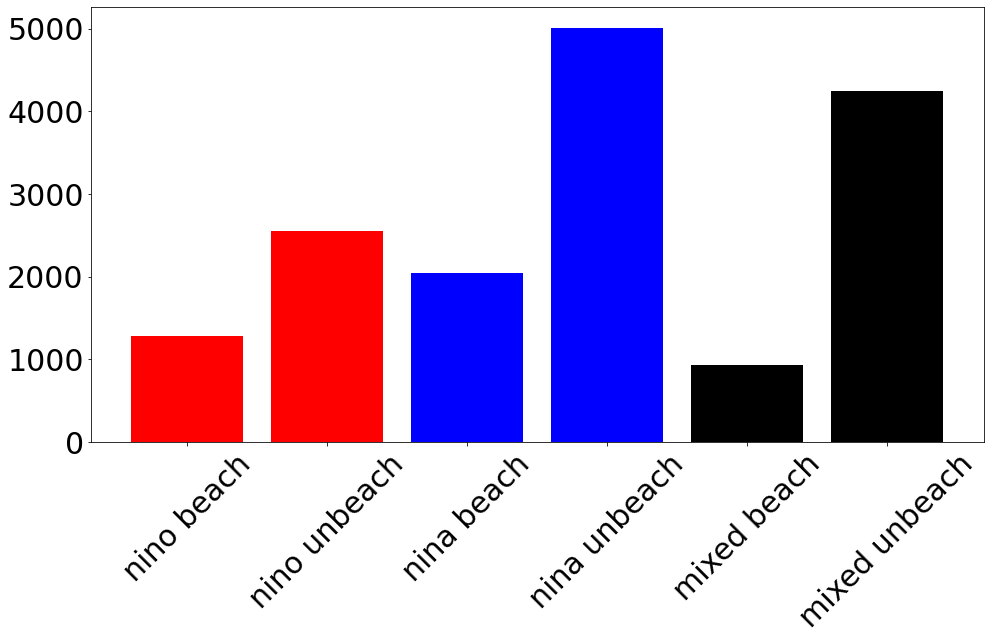

In [159]:
#let's consider their relative sizes:

# find the ratios of beach to unbeach for each:
nino_ratio = len(el_nino_traj_beach) / len(el_nino_traj_unbeach)

nina_ratio = len(la_nina_traj_beach) / len(la_nina_traj_unbeach)

mixed_ratio = len(mixed_ENSO_traj_beach) / len(mixed_ENSO_traj_unbeach)

print('nino ratio: ' + str(nino_ratio))
print('nina ratio: ' + str(nina_ratio))
print('mixed ratio: ' + str(mixed_ratio))


plt.figure(figsize=(16, 8))
colors = ['red', 'red', 'blue', 'blue', 'black', 'black']
plt.bar(["nino beach", "nino unbeach", "nina beach", "nina unbeach", "mixed beach", "mixed unbeach"], 
        [len(el_nino_traj_beach), len(el_nino_traj_unbeach), len(la_nina_traj_beach),len(la_nina_traj_unbeach), 
         len(mixed_ENSO_traj_beach), len(mixed_ENSO_traj_unbeach)], color = colors)

plt.xticks(rotation=45, ha='center') 
plt.show()

nino ratio: 0.5043205027494109
nina ratio: 0.5043205027494109


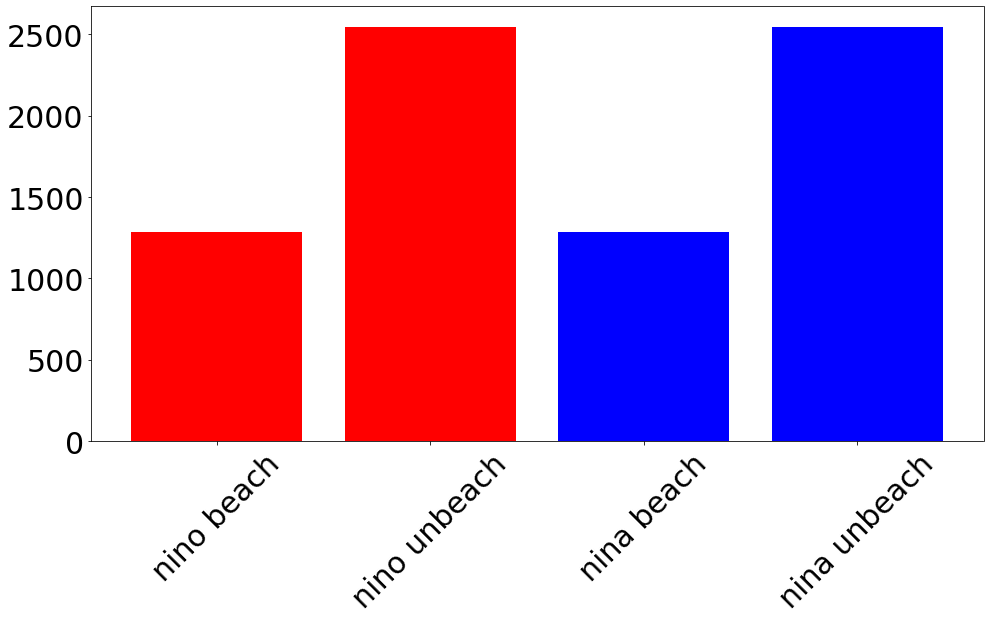

In [160]:
# We should normalize the ratios of beached to unbeached across nino, nina, and mixed so we can effectively compare beaching probabilities
# We sample all ENSO states of both beach and unbeach to the lowest length count in each respective beaching condition.

np.random.seed(42) # the answer to the ultimate question i.e., random results are made reproducible
# 1171, 2741
el_nino_traj_beach_subset = np.random.choice(el_nino_traj_beach, size=1284, replace=False)
el_nino_traj_unbeach_subset = np.random.choice(el_nino_traj_unbeach, size=2546, replace=False)

la_nina_traj_beach_subset = np.random.choice(la_nina_traj_beach, size=1284, replace=False)
la_nina_traj_unbeach_subset = np.random.choice(la_nina_traj_unbeach, size=2546, replace=False)

#mixed_ENSO_traj_beach_subset = np.random.choice(mixed_ENSO_traj_beach, size=931, replace=False)
#mixed_ENSO_traj_unbeach_subset = np.random.choice(mixed_ENSO_traj_unbeach, size=2546, replace=False)


# find the ratios of beach to unbeach for each:
nino_ratio = len(el_nino_traj_beach_subset) / len(el_nino_traj_unbeach_subset)

nina_ratio = len(la_nina_traj_beach_subset) / len(la_nina_traj_unbeach_subset)

#mixed_ratio = len(mixed_ENSO_traj_beach_subset) / len(mixed_ENSO_traj_unbeach_subset)

print('nino ratio: ' + str(nino_ratio))
print('nina ratio: ' + str(nina_ratio))
#print('mixed ratio: ' + str(mixed_ratio))


plt.figure(figsize=(16, 8))
#colors = ['red', 'red', 'blue', 'blue']#, 'black', 'black']
plt.bar(["nino beach", "nino unbeach", "nina beach", "nina unbeach"],# "mixed beach", "mixed unbeach"], 
        [len(el_nino_traj_beach_subset), len(el_nino_traj_unbeach_subset), len(la_nina_traj_beach_subset), len(la_nina_traj_unbeach_subset)], 
        color=['red', 'red', 'blue', 'blue'])
         ,#len(mixed_ENSO_traj_beach_subset), len(mixed_ENSO_traj_unbeach_subset)], color = colors)

plt.xticks(rotation=45, ha='center') 
plt.show()

In [161]:
# Beach
# Separate data into nino, nina, mixed based on ID
beach_nino = beach[beach['id'].isin(el_nino_traj_beach_subset)]
beach_nina = beach[beach['id'].isin(la_nina_traj_beach_subset)]
#beach_mixed = beach[beach['id'].isin(mixed_ENSO_traj_beach_subset)]

# Unbeach
# Separate data into nino, nina, mixed based on ID
unbeach_nino = unbeach[unbeach['id'].isin(el_nino_traj_unbeach_subset)]
unbeach_nina = unbeach[unbeach['id'].isin(la_nina_traj_unbeach_subset)]
#unbeach_mixed = unbeach[unbeach['id'].isin(mixed_ENSO_traj_unbeach_subset)]

In [162]:
# during el nino

In [163]:
# redefine outdated variables
beach_undrogued = beach_nino
unbeach_undrogued = unbeach_nino

# get beached lats and lons
beach_undrogued_lats = np.array(beach_undrogued['lat'])
beach_undrogued_longs = np.array(beach_undrogued['lon'])

# get unbeached lats and lons
unbeach_undrogued_lats = np.array(unbeach_undrogued['lat'])
unbeach_undrogued_longs = np.array(unbeach_undrogued['lon'])

# concatenate them together into single lat/lon lists
lats = np.concatenate((beach_undrogued_lats, unbeach_undrogued_lats))
longs = np.concatenate((beach_undrogued_longs, unbeach_undrogued_longs))

# let's use sci_stats.binned_statistic_2d to bin by lat/lon and count

# beached
n_lons, n_lats = n_lons_u, n_lats_u # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

beach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    beach_undrogued_longs,beach_undrogued_lats,values=beach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

# unbeached
n_lons, n_lats = n_lons_u, n_lats_u # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

unbeach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    unbeach_undrogued_longs,unbeach_undrogued_lats,values=unbeach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])
def probability_of_beaching(beached_count, unbeached_count):
    probability = beached_count / (beached_count + unbeached_count)
    return probability
nino_probability_undrogued = probability_of_beaching(beach_undrogued_stat, unbeach_undrogued_stat)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


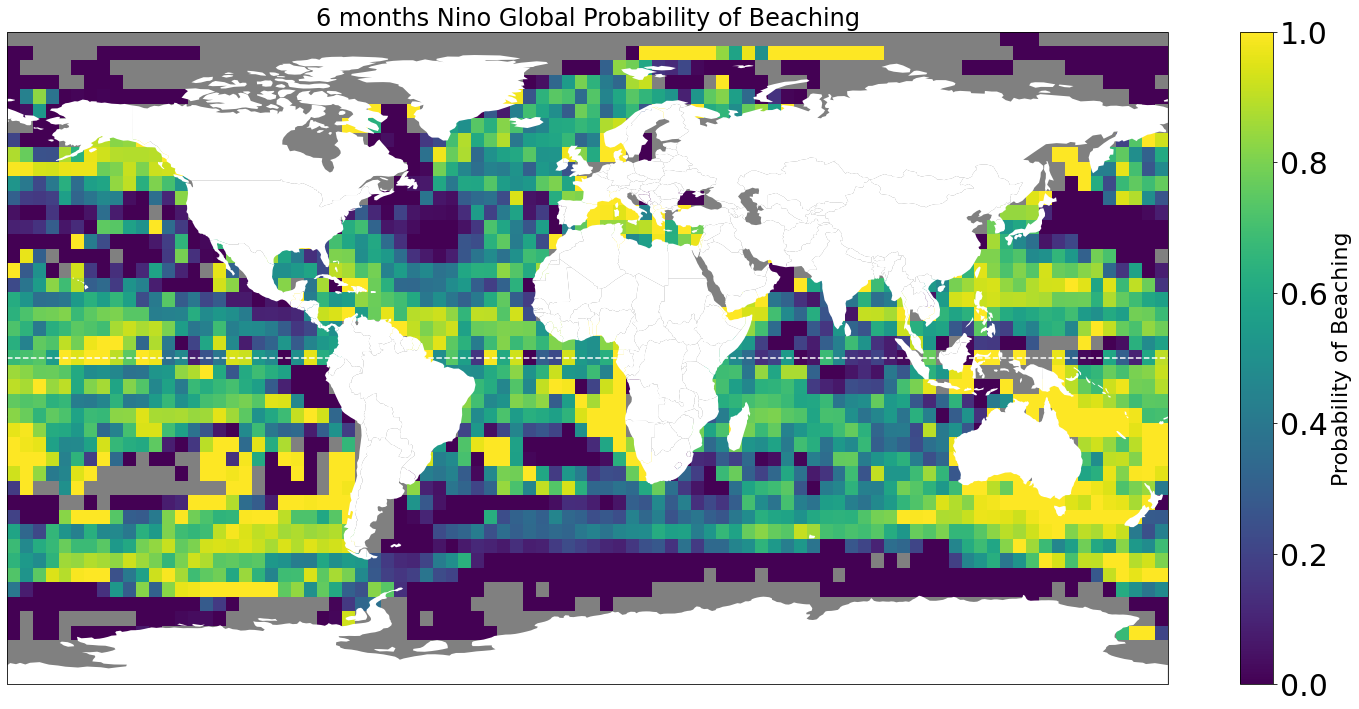

In [164]:
# Given location, probability of beaching
# Undrogued

fig = plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# colormap
cmap = plt.cm.get_cmap("viridis").copy()
cmap.set_bad('grey')

# plot hist on world
plt.imshow(nino_probability_undrogued.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap)

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(label='Probability of Beaching')
ax.set_aspect('auto')
plt.title('6 months Nino Global Probability of Beaching')
plt.axhline(y=0, color='white', linestyle='--', label='Equator')

In [165]:
# during la nina

In [166]:
# redefine outdated variables
beach_undrogued = beach_nina
unbeach_undrogued = unbeach_nina

# get beached lats and lons
beach_undrogued_lats = np.array(beach_undrogued['lat'])
beach_undrogued_longs = np.array(beach_undrogued['lon'])

# get unbeached lats and lons
unbeach_undrogued_lats = np.array(unbeach_undrogued['lat'])
unbeach_undrogued_longs = np.array(unbeach_undrogued['lon'])

# concatenate them together into single lat/lon lists
lats = np.concatenate((beach_undrogued_lats, unbeach_undrogued_lats))
longs = np.concatenate((beach_undrogued_longs, unbeach_undrogued_longs))

# let's use sci_stats.binned_statistic_2d to bin by lat/lon and count

# beached
n_lons, n_lats = n_lons_u, n_lats_u # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

beach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    beach_undrogued_longs,beach_undrogued_lats,values=beach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

# unbeached
n_lons, n_lats = n_lons_u, n_lats_u # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

unbeach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    unbeach_undrogued_longs,unbeach_undrogued_lats,values=unbeach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])
def probability_of_beaching(beached_count, unbeached_count):
    probability = beached_count / (beached_count + unbeached_count)
    return probability
nina_probability_undrogued = probability_of_beaching(beach_undrogued_stat, unbeach_undrogued_stat)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


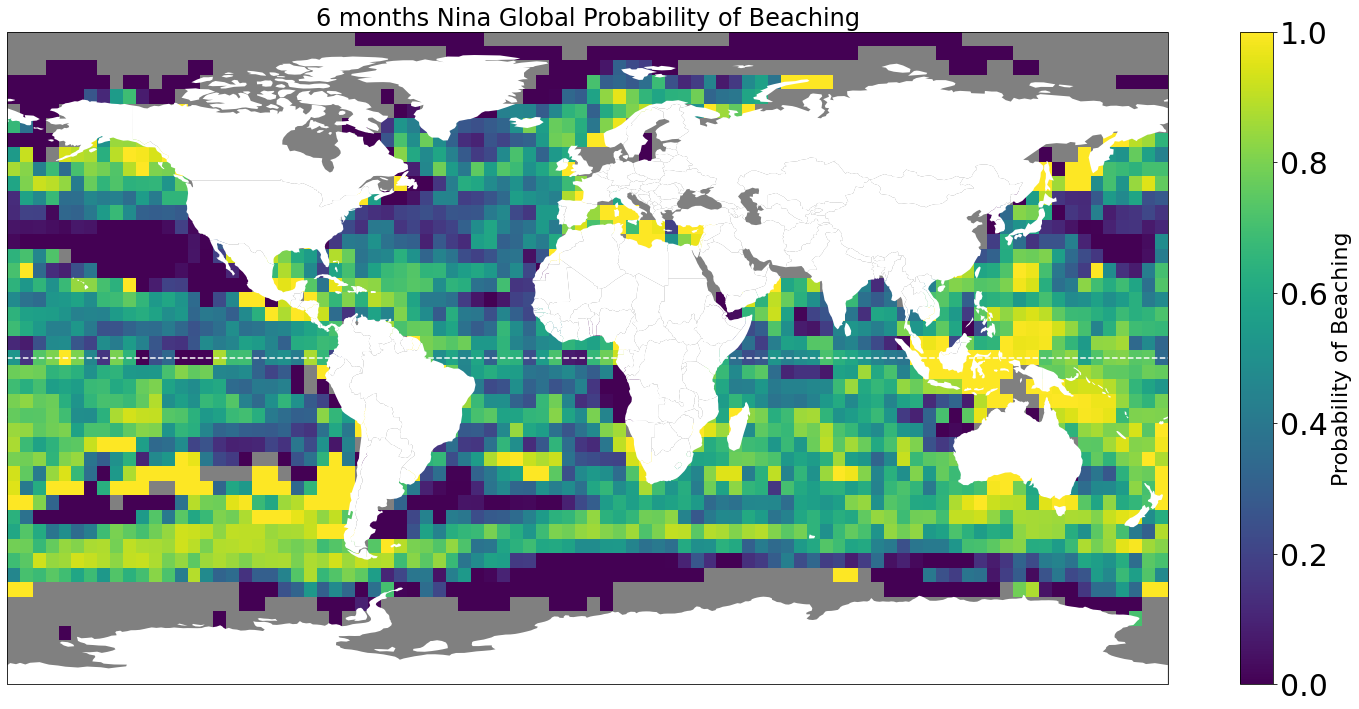

In [167]:
# Given location, probability of beaching
# Undrogued

fig = plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# colormap
cmap = plt.cm.get_cmap("viridis").copy()
cmap.set_bad('grey')

# plot hist on world
plt.imshow(nina_probability_undrogued.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap)

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(label='Probability of Beaching')
ax.set_aspect('auto')
plt.title('6 months Nina Global Probability of Beaching')
plt.axhline(y=0, color='white', linestyle='--', label='Equator')

In [168]:
# calculate difference for 6 months
difference_6_months = nino_probability_undrogued.T - nina_probability_undrogued.T

# now, let's look at 1 year instead of 6 months:

In [169]:
# grab 12 months to beach
seconds_in_yr = 60 * 60 * 24 * 365
beach_12 = beach[beach['time_to_beach'] <= seconds_in_yr]

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


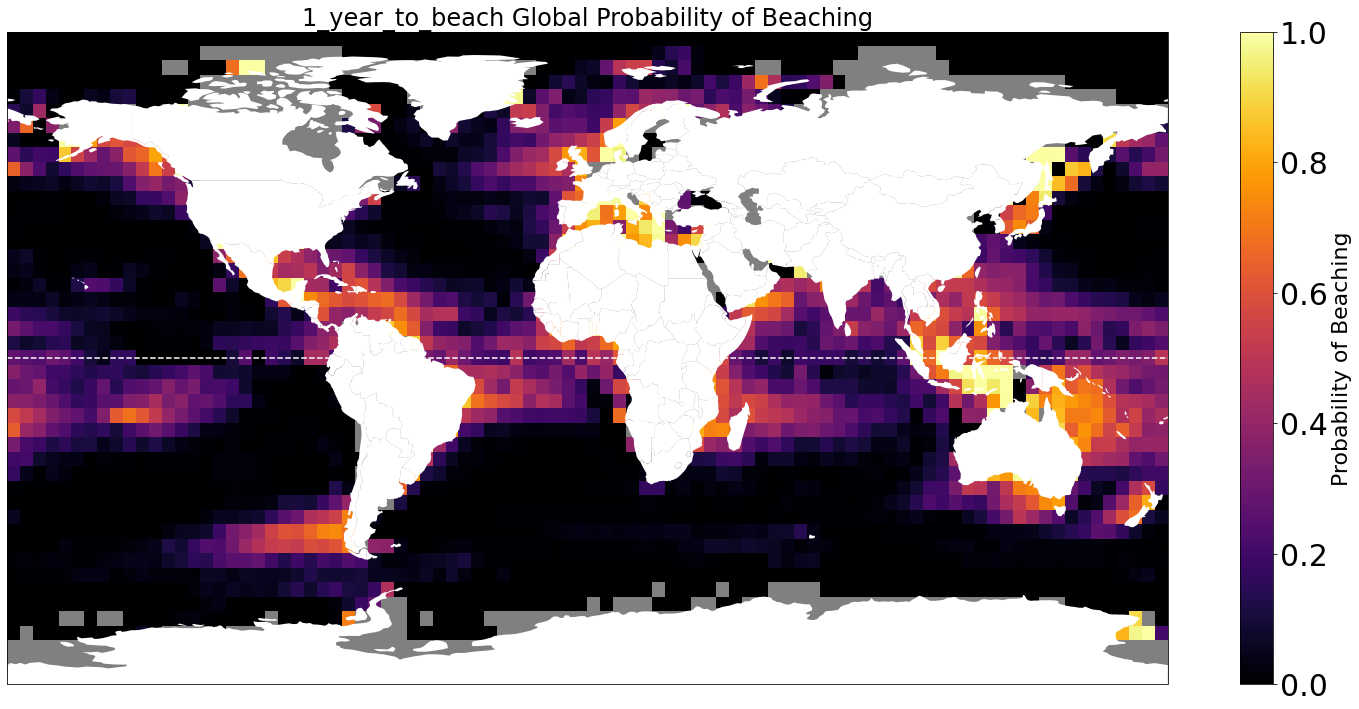

In [170]:
# this code comes from 'probability of beaching.ipynb'

# define probability of beaching function
def probability_of_beaching(beached_count, unbeached_count):
    probability = beached_count / (beached_count + unbeached_count)
    return probability

# get beached lats and lons
beach_undrogued_lats = np.array(beach_12['lat'])
beach_undrogued_longs = np.array(beach_12['lon'])

# get unbeached lats and lons
unbeach_undrogued_lats = np.array(unbeach['lat'])
unbeach_undrogued_longs = np.array(unbeach['lon'])

# concatenate them together into single lat/lon lists
lats = np.concatenate((beach_undrogued_lats, unbeach_undrogued_lats))
longs = np.concatenate((beach_undrogued_longs, unbeach_undrogued_longs))

# let's use sci_stats.binned_statistic_2d to bin by lat/lon and count

# beached
n_lons, n_lats = n_lons_u, n_lats_u # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

beach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    beach_undrogued_longs,beach_undrogued_lats,values=beach_12['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

# unbeached
n_lons, n_lats = n_lons_u, n_lats_u # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

unbeach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    unbeach_undrogued_longs,unbeach_undrogued_lats,values=unbeach['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

probability_1_year = probability_of_beaching(beach_undrogued_stat, unbeach_undrogued_stat)


# Given location, probability of beaching
# Undrogued

fig = plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# colormap
cmap = plt.cm.get_cmap("inferno").copy()
cmap.set_bad('grey')

# plot hist on world
plt.imshow(probability_6_months.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap)

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(label='Probability of Beaching')
ax.set_aspect('auto')
plt.title('1_year_to_beach Global Probability of Beaching')
plt.axhline(y=0, color='white', linestyle='--', label='Equator')

In [171]:
# now working from the end of 'ENSO_classification.ipynb'
# now, we consider the relative amount of time each drifter trajectory spends in the temporal el nino or la nina regimes. 
# If a drifter trajectory spends more than 80% of time in one regime or the other, we classify that drifter trajectory as an el nino or 
# la nina drifter trajectory, thus grouping our trajectories by temporal ENSO regime. If a drifter trajectory spends less than 80% of time 
# in either regime, then we classify that drifter trajectory as a 'mixed_ENSO' drifter trajectory

In [172]:
# 95 percent seems good
percent_parameter = 95

# beach
el_nino_traj_beach, la_nina_traj_beach, mixed_ENSO_traj_beach = classify_ENSO_trajectories(beach_12, percent_parameter)

# unbeach
el_nino_traj_unbeach, la_nina_traj_unbeach, mixed_ENSO_traj_unbeach = classify_ENSO_trajectories(unbeach, percent_parameter)

nino ratio: 0.4509033778476041
nina ratio: 0.3415802075019952
mixed ratio: 0.32791519434628974


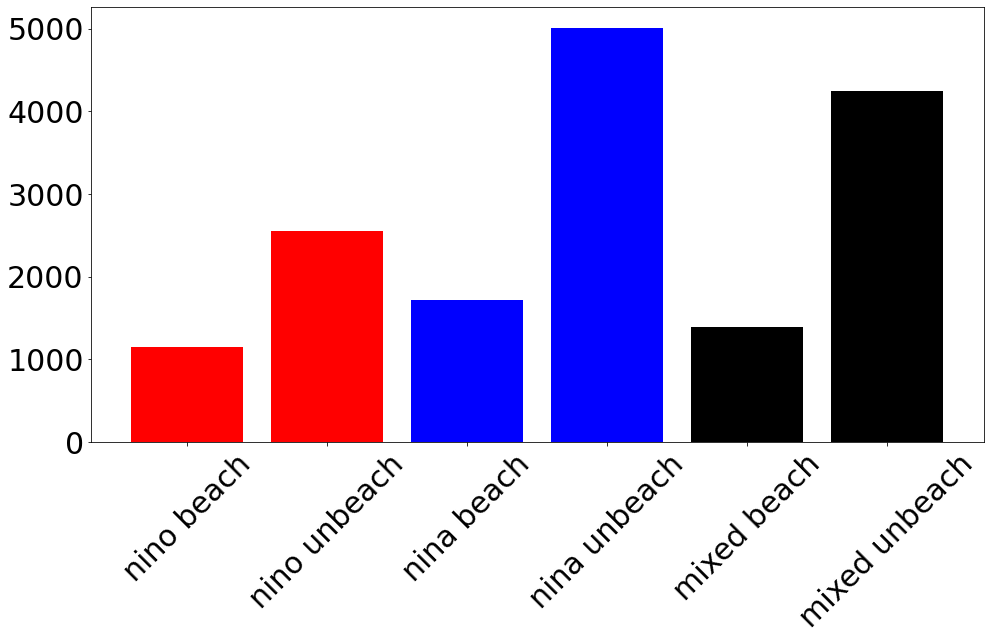

In [173]:
#let's consider their relative sizes:

# find the ratios of beach to unbeach for each:
nino_ratio = len(el_nino_traj_beach) / len(el_nino_traj_unbeach)

nina_ratio = len(la_nina_traj_beach) / len(la_nina_traj_unbeach)

mixed_ratio = len(mixed_ENSO_traj_beach) / len(mixed_ENSO_traj_unbeach)

print('nino ratio: ' + str(nino_ratio))
print('nina ratio: ' + str(nina_ratio))
print('mixed ratio: ' + str(mixed_ratio))


plt.figure(figsize=(16, 8))
colors = ['red', 'red', 'blue', 'blue', 'black', 'black']
plt.bar(["nino beach", "nino unbeach", "nina beach", "nina unbeach", "mixed beach", "mixed unbeach"], 
        [len(el_nino_traj_beach), len(el_nino_traj_unbeach), len(la_nina_traj_beach),len(la_nina_traj_unbeach), 
         len(mixed_ENSO_traj_beach), len(mixed_ENSO_traj_unbeach)], color = colors)

plt.xticks(rotation=45, ha='center') 
plt.show()

In [174]:
len(el_nino_traj_beach)

1148

nino ratio: 0.4509033778476041
nina ratio: 0.4509033778476041


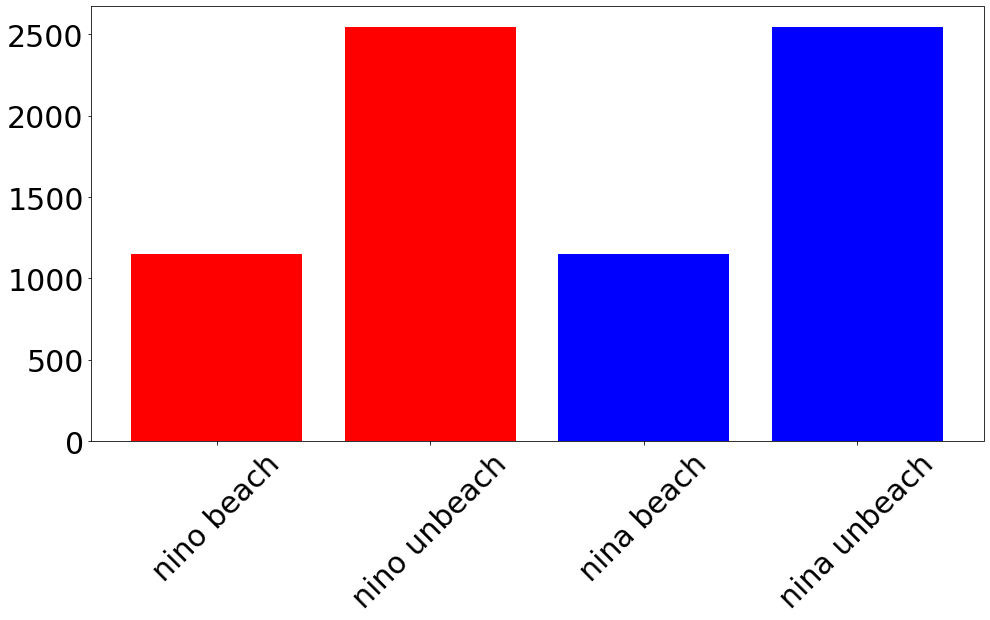

In [175]:
# We should normalize the ratios of beached to unbeached across nino, nina, and mixed so we can effectively compare beaching probabilities
# We sample all ENSO states of both beach and unbeach to the lowest length count in each respective beaching condition.

np.random.seed(42) # the answer to the ultimate question i.e., random results are made reproducible
# 1171, 2741
el_nino_traj_beach_subset = np.random.choice(el_nino_traj_beach, size=1148, replace=False)
el_nino_traj_unbeach_subset = np.random.choice(el_nino_traj_unbeach, size=2546, replace=False)

la_nina_traj_beach_subset = np.random.choice(la_nina_traj_beach, size=1148, replace=False)
la_nina_traj_unbeach_subset = np.random.choice(la_nina_traj_unbeach, size=2546, replace=False)

#mixed_ENSO_traj_beach_subset = np.random.choice(mixed_ENSO_traj_beach, size=931, replace=False)
#mixed_ENSO_traj_unbeach_subset = np.random.choice(mixed_ENSO_traj_unbeach, size=2546, replace=False)


# find the ratios of beach to unbeach for each:
nino_ratio = len(el_nino_traj_beach_subset) / len(el_nino_traj_unbeach_subset)

nina_ratio = len(la_nina_traj_beach_subset) / len(la_nina_traj_unbeach_subset)

#mixed_ratio = len(mixed_ENSO_traj_beach_subset) / len(mixed_ENSO_traj_unbeach_subset)

print('nino ratio: ' + str(nino_ratio))
print('nina ratio: ' + str(nina_ratio))
#print('mixed ratio: ' + str(mixed_ratio))


plt.figure(figsize=(16, 8))
#colors = ['red', 'red', 'blue', 'blue']#, 'black', 'black']
plt.bar(["nino beach", "nino unbeach", "nina beach", "nina unbeach"],# "mixed beach", "mixed unbeach"], 
        [len(el_nino_traj_beach_subset), len(el_nino_traj_unbeach_subset), len(la_nina_traj_beach_subset), len(la_nina_traj_unbeach_subset)], 
        color=['red', 'red', 'blue', 'blue'])
         ,#len(mixed_ENSO_traj_beach_subset), len(mixed_ENSO_traj_unbeach_subset)], color = colors)

plt.xticks(rotation=45, ha='center') 
plt.show()

In [176]:
# Beach
# Separate data into nino, nina, mixed based on ID
beach_nino = beach[beach['id'].isin(el_nino_traj_beach_subset)]
beach_nina = beach[beach['id'].isin(la_nina_traj_beach_subset)]
#beach_mixed = beach[beach['id'].isin(mixed_ENSO_traj_beach_subset)]

# Unbeach
# Separate data into nino, nina, mixed based on ID
unbeach_nino = unbeach[unbeach['id'].isin(el_nino_traj_unbeach_subset)]
unbeach_nina = unbeach[unbeach['id'].isin(la_nina_traj_unbeach_subset)]
#unbeach_mixed = unbeach[unbeach['id'].isin(mixed_ENSO_traj_unbeach_subset)]

In [177]:
# el nino

In [178]:
# redefine outdated variables
beach_undrogued = beach_nino
unbeach_undrogued = unbeach_nino

# get beached lats and lons
beach_undrogued_lats = np.array(beach_undrogued['lat'])
beach_undrogued_longs = np.array(beach_undrogued['lon'])

# get unbeached lats and lons
unbeach_undrogued_lats = np.array(unbeach_undrogued['lat'])
unbeach_undrogued_longs = np.array(unbeach_undrogued['lon'])

# concatenate them together into single lat/lon lists
lats = np.concatenate((beach_undrogued_lats, unbeach_undrogued_lats))
longs = np.concatenate((beach_undrogued_longs, unbeach_undrogued_longs))

# let's use sci_stats.binned_statistic_2d to bin by lat/lon and count

# beached
n_lons, n_lats = n_lons_u, n_lats_u # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

beach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    beach_undrogued_longs,beach_undrogued_lats,values=beach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

# unbeached
n_lons, n_lats = n_lons_u, n_lats_u # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

unbeach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    unbeach_undrogued_longs,unbeach_undrogued_lats,values=unbeach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])
def probability_of_beaching(beached_count, unbeached_count):
    probability = beached_count / (beached_count + unbeached_count)
    return probability
nino_probability_undrogued = probability_of_beaching(beach_undrogued_stat, unbeach_undrogued_stat)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


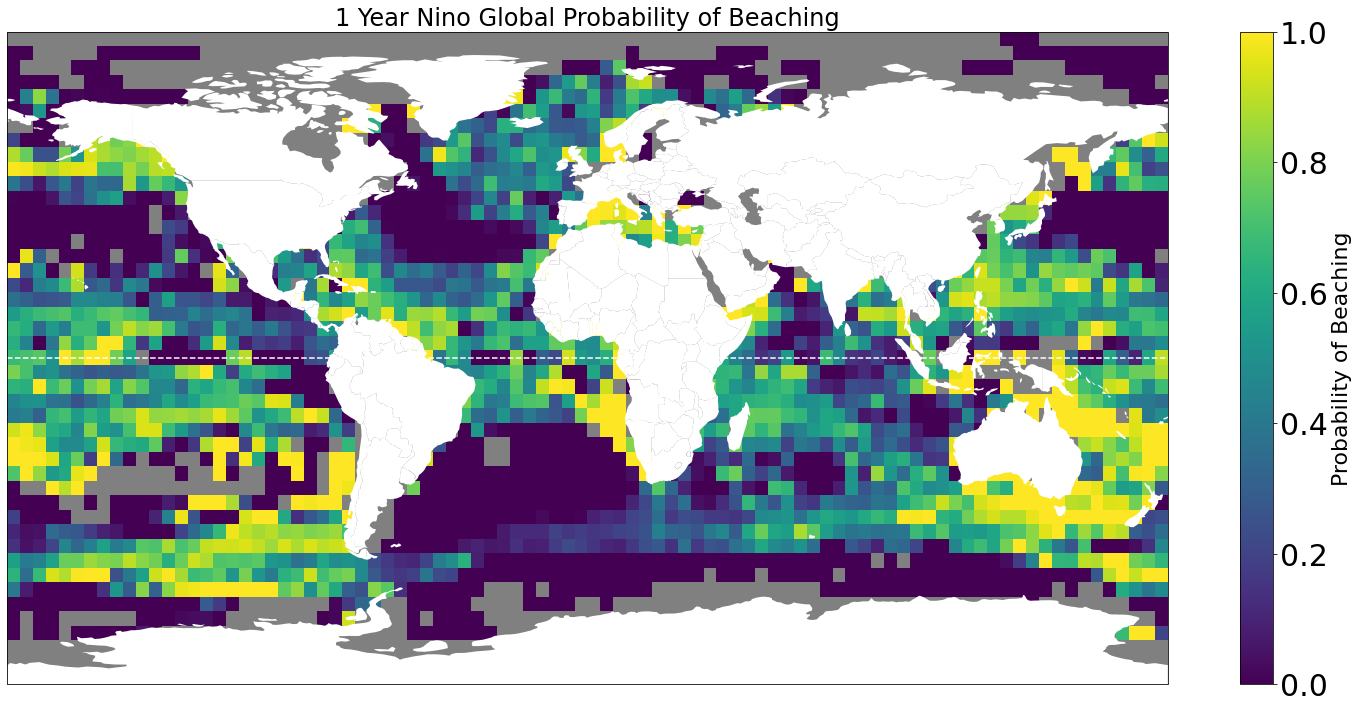

In [179]:
# Given location, probability of beaching
# Undrogued

fig = plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# colormap
cmap = plt.cm.get_cmap("viridis").copy()
cmap.set_bad('grey')

# plot hist on world
plt.imshow(nino_probability_undrogued.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap)

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(label='Probability of Beaching')
ax.set_aspect('auto')
plt.title('1 Year Nino Global Probability of Beaching')
plt.axhline(y=0, color='white', linestyle='--', label='Equator')

In [180]:
# la nina

In [181]:
# redefine outdated variables
beach_undrogued = beach_nina
unbeach_undrogued = unbeach_nina

# get beached lats and lons
beach_undrogued_lats = np.array(beach_undrogued['lat'])
beach_undrogued_longs = np.array(beach_undrogued['lon'])

# get unbeached lats and lons
unbeach_undrogued_lats = np.array(unbeach_undrogued['lat'])
unbeach_undrogued_longs = np.array(unbeach_undrogued['lon'])

# concatenate them together into single lat/lon lists
lats = np.concatenate((beach_undrogued_lats, unbeach_undrogued_lats))
longs = np.concatenate((beach_undrogued_longs, unbeach_undrogued_longs))

# let's use sci_stats.binned_statistic_2d to bin by lat/lon and count

# beached
n_lons, n_lats = n_lons_u, n_lats_u # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

beach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    beach_undrogued_longs,beach_undrogued_lats,values=beach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

# unbeached
n_lons, n_lats = n_lons_u, n_lats_u # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

unbeach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    unbeach_undrogued_longs,unbeach_undrogued_lats,values=unbeach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])
def probability_of_beaching(beached_count, unbeached_count):
    probability = beached_count / (beached_count + unbeached_count)
    return probability
nina_probability_undrogued = probability_of_beaching(beach_undrogued_stat, unbeach_undrogued_stat)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


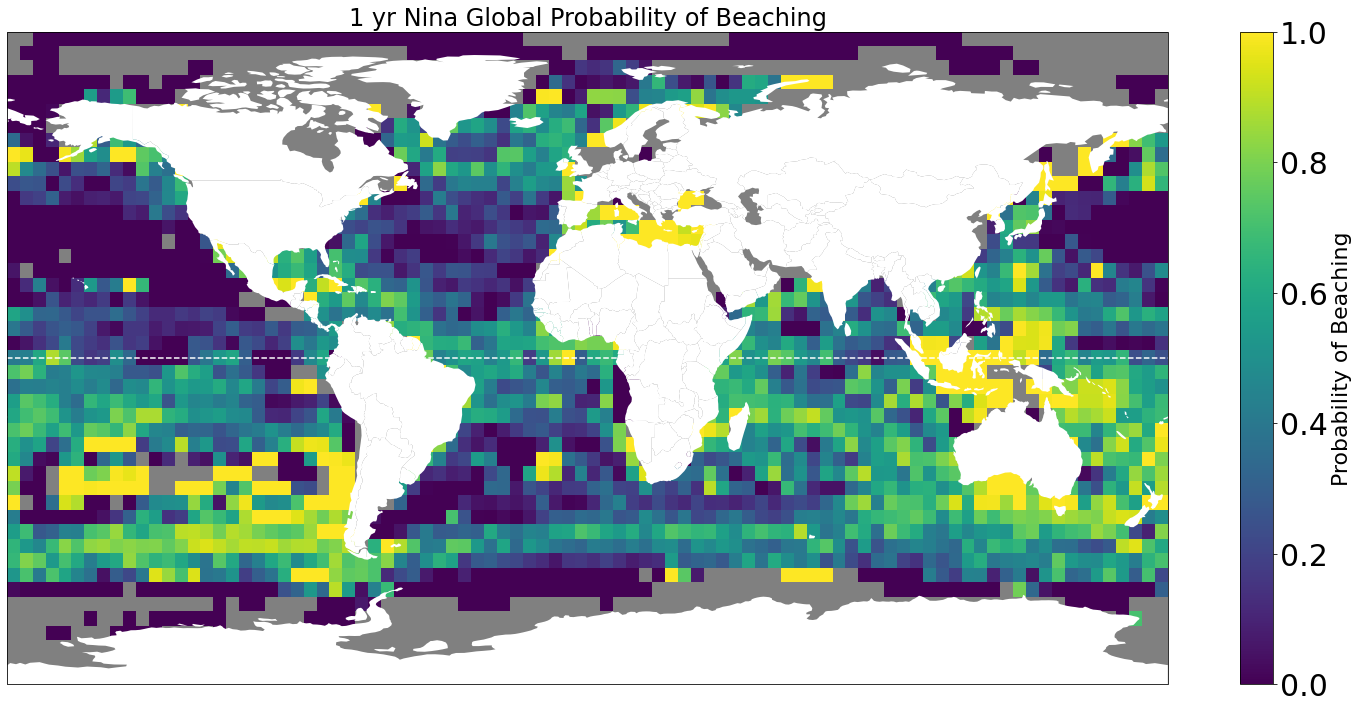

In [182]:
# Given location, probability of beaching
# Undrogued

fig = plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# colormap
cmap = plt.cm.get_cmap("viridis").copy()
cmap.set_bad('grey')

# plot hist on world
plt.imshow(nina_probability_undrogued.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap)

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(label='Probability of Beaching')
ax.set_aspect('auto')
plt.title('1 yr Nina Global Probability of Beaching')
plt.axhline(y=0, color='white', linestyle='--', label='Equator')

In [183]:
# calculate 1 year difference
difference_1_year = nino_probability_undrogued.T - nina_probability_undrogued.T

# let's consider the EL NINO-LA NINA differences for both 6 months and 1 year to beach

/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6611: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6612: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


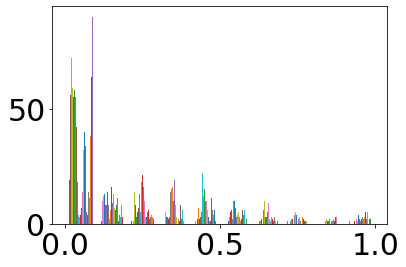

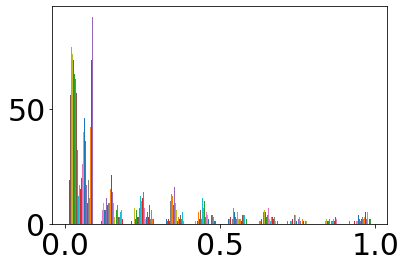

In [184]:
plt.hist(probability_1_year)
plt.show()
plt.hist(probability_6_months)
plt.show()

In [185]:
# probability of beaching:
difference_1_to_6_months = probability_1_year - probability_6_months

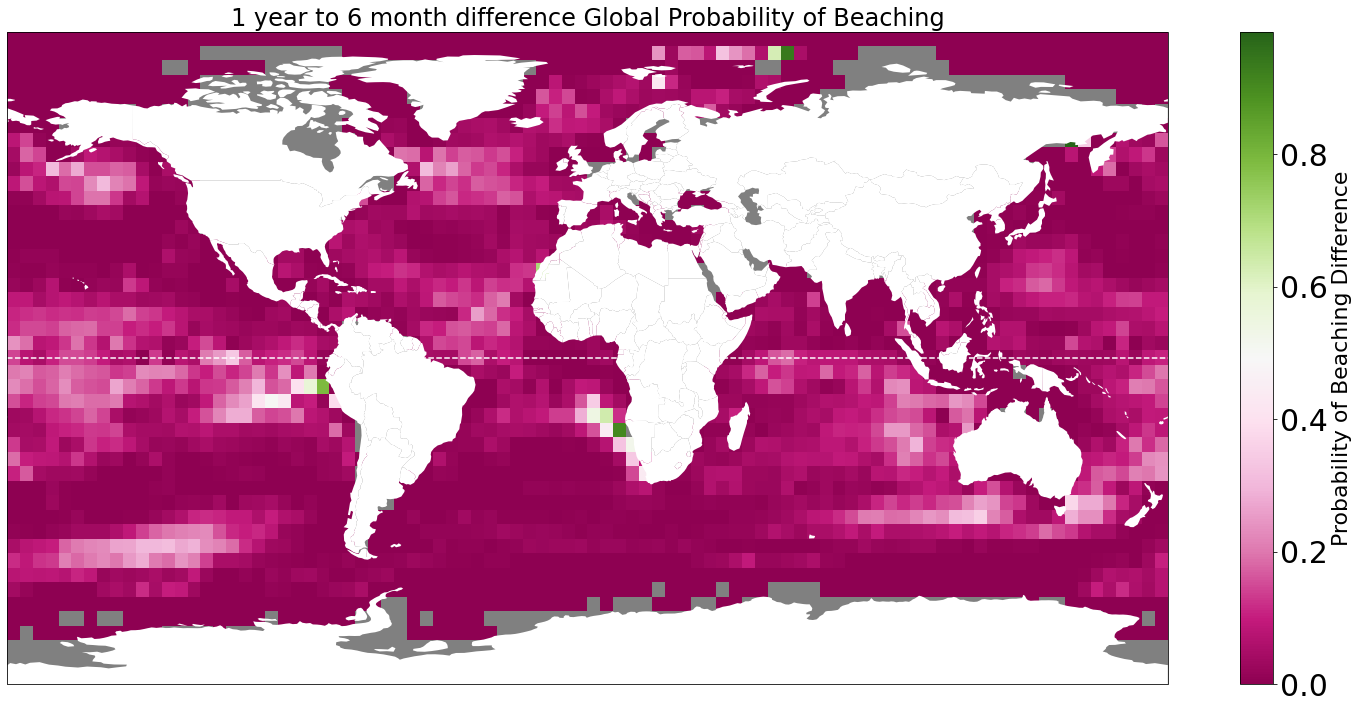

In [186]:
fig = plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# colormap
cmap = plt.cm.get_cmap("PiYG").copy()
cmap.set_bad('grey')

# plot hist on world
plt.imshow(difference_1_to_6_months.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap)

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(label='Probability of Beaching Difference')
ax.set_aspect('auto')
plt.title('1 year to 6 month difference Global Probability of Beaching')
plt.axhline(y=0, color='white', linestyle='--', label='Equator')
plt.show()

#### in the above map, green and white show where 1 year has a higher probability of beaching than 6 month data, which makes sense as this occurs generally furhter from beahcing locations (?)

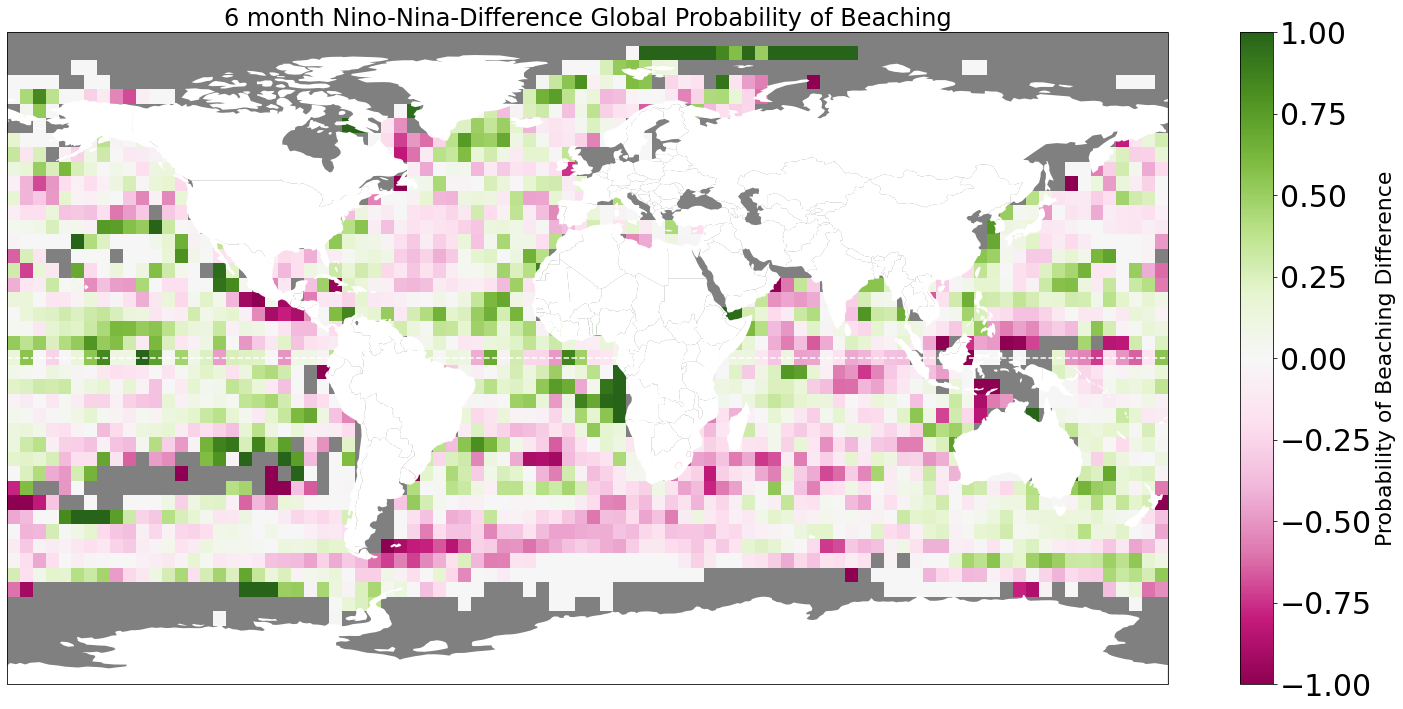

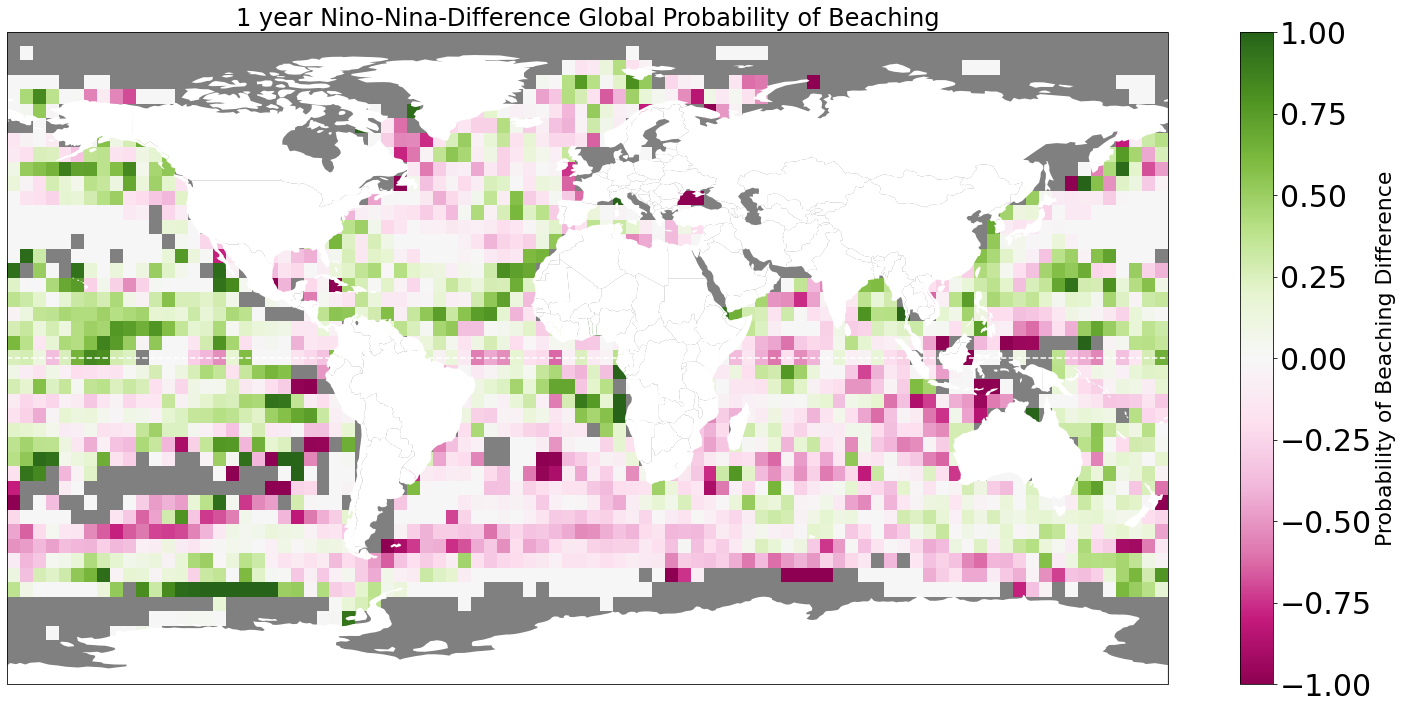

In [187]:
# ENSO

# Given location, probability of beaching
# Undrogued

# 6 months
fig = plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# colormap
cmap = plt.cm.get_cmap("PiYG").copy()
cmap.set_bad('grey')

# plot hist on world
plt.imshow(difference_6_months, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap)

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(label='Probability of Beaching Difference')
ax.set_aspect('auto')
plt.title('6 month Nino-Nina-Difference Global Probability of Beaching')
plt.axhline(y=0, color='white', linestyle='--', label='Equator')
plt.show()

# 1 year
fig = plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# colormap
cmap = plt.cm.get_cmap("PiYG").copy()
cmap.set_bad('grey')

# plot hist on world
plt.imshow(difference_1_year, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap)

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(label='Probability of Beaching Difference')
ax.set_aspect('auto')
plt.title('1 year Nino-Nina-Difference Global Probability of Beaching')
plt.axhline(y=0, color='white', linestyle='--', label='Equator')
plt.show()

### In both maps above, green colors indicate a higher probability of beaching during nino, pink indicate a higher probability of beaching during nina, and white indicate equal probability

# Now, we take a closer look at some regions of the 1 year difference:

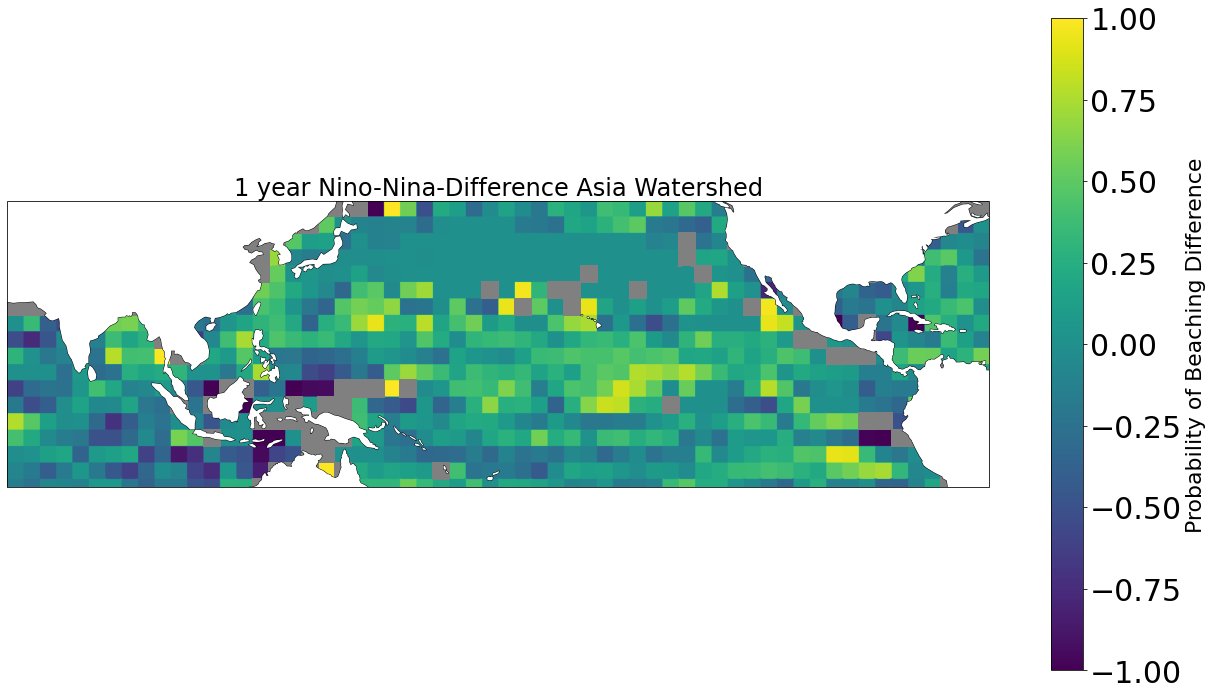

In [217]:
# Asia 1 year
plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-180))
ax.set_extent([120, -120, -20, 50], crs=ccrs.PlateCarree(central_longitude=-180))

# colormap
cmap = plt.cm.get_cmap("viridis").copy()
cmap.set_bad('grey')

# plot hist on world
plt.imshow(difference_1_year, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap, transform = ccrs.PlateCarree())

# Load the world shapefile from GeoPandas
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
ax.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax.add_feature(land_feature)

plt.colorbar(label='Probability of Beaching Difference')
#ax.set_aspect('auto')
plt.title('1 year Nino-Nina-Difference Asia Watershed')
plt.show()

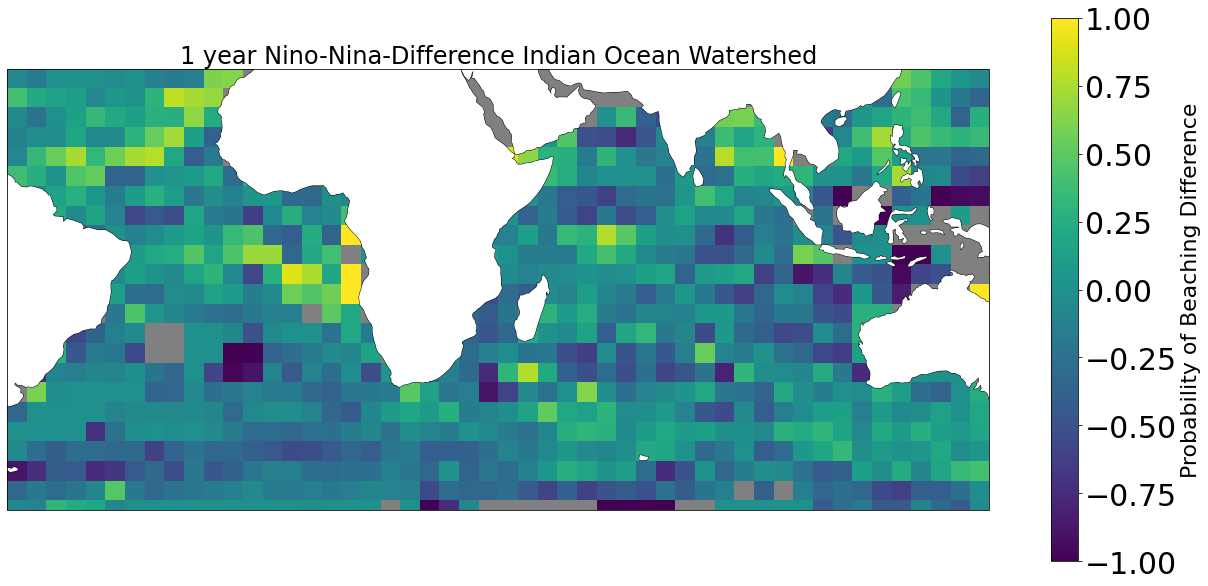

In [219]:
# Indian_Ocean 1 year
plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(22, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-60, 140, -60, 30], crs=ccrs.PlateCarree())

# colormap
cmap = plt.cm.get_cmap("viridis").copy()
cmap.set_bad('grey')

# plot hist on world
plt.imshow(difference_1_year, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap, transform = ccrs.PlateCarree())

# Load the world shapefile from GeoPandas
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
ax.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax.add_feature(land_feature)

plt.colorbar(label='Probability of Beaching Difference')
#ax.set_aspect('auto')
plt.title('1 year Nino-Nina-Difference Indian_Ocean Watershed')
plt.show()

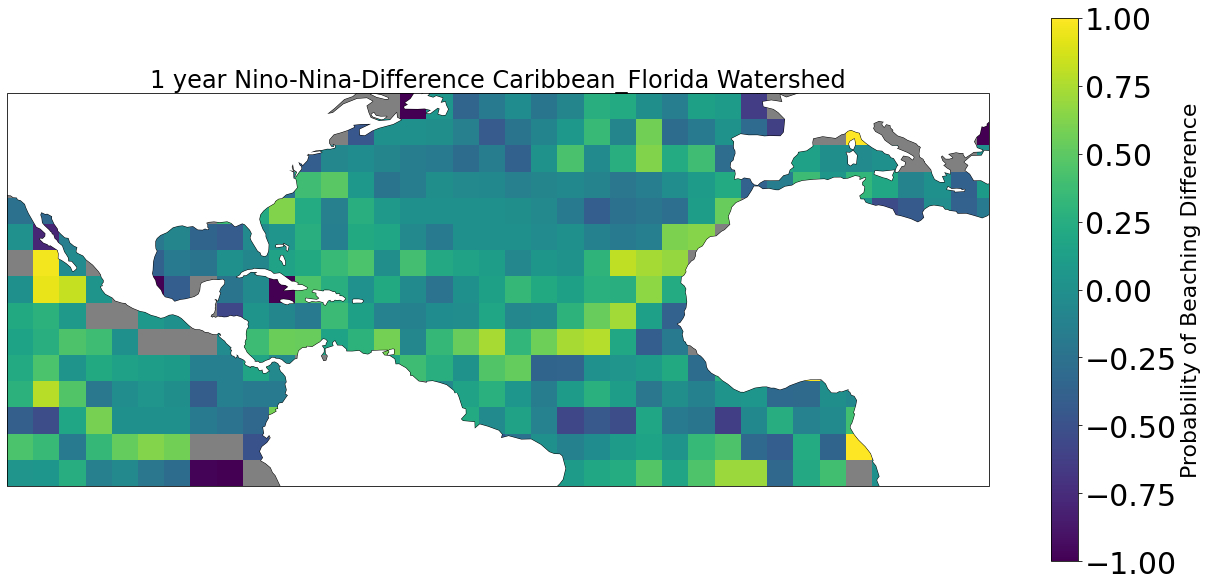

In [220]:
# Caribbean_Florida 1 year
plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(22, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-120, 30, -10, 50], crs=ccrs.PlateCarree())

# colormap
cmap = plt.cm.get_cmap("viridis").copy()
cmap.set_bad('grey')

# plot hist on world
plt.imshow(difference_1_year, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap, transform = ccrs.PlateCarree())

# Load the world shapefile from GeoPandas
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
ax.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax.add_feature(land_feature)

plt.colorbar(label='Probability of Beaching Difference')
#ax.set_aspect('auto')
plt.title('1 year Nino-Nina-Difference Caribbean_Florida Watershed')
plt.show()

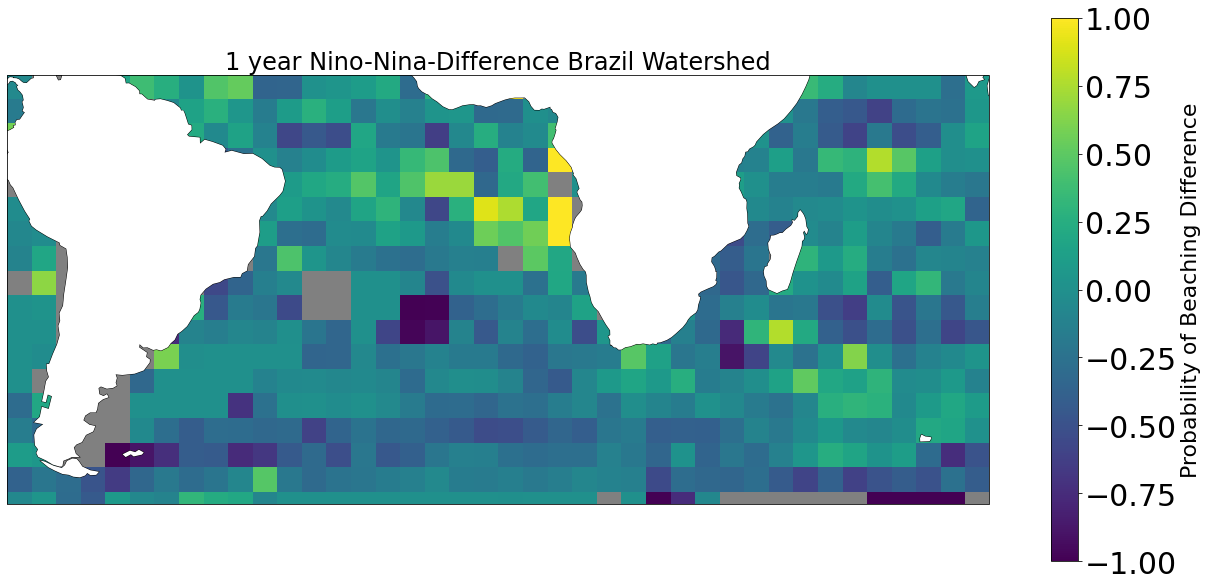

In [221]:
# Brazil 1 year
plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(22, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-80, 80, -60, 10], crs=ccrs.PlateCarree())

# colormap
cmap = plt.cm.get_cmap("viridis").copy()
cmap.set_bad('grey')

# plot hist on world
plt.imshow(difference_1_year, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap, transform = ccrs.PlateCarree())

# Load the world shapefile from GeoPandas
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
ax.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax.add_feature(land_feature)

plt.colorbar(label='Probability of Beaching Difference')
#ax.set_aspect('auto')
plt.title('1 year Nino-Nina-Difference Brazil Watershed')
plt.show()

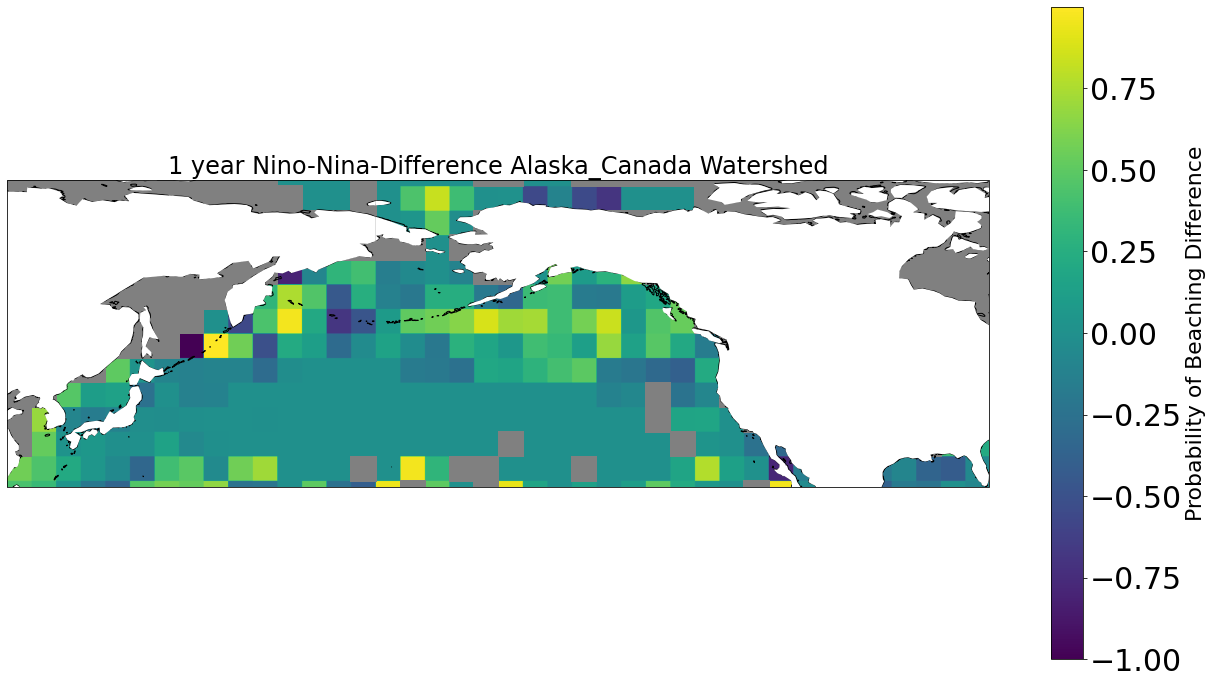

In [222]:
# Alaska_Canada 1 year
plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-180))
ax.set_extent([100, -60, 25, 75], crs=ccrs.PlateCarree(central_longitude=-180))

# colormap
cmap = plt.cm.get_cmap("viridis").copy()
cmap.set_bad('grey')

# plot hist on world
plt.imshow(difference_1_year, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap, transform = ccrs.PlateCarree())

# Load the world shapefile from GeoPandas
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
ax.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax.add_feature(land_feature)

plt.colorbar(label='Probability of Beaching Difference')
#ax.set_aspect('auto')
plt.title('1 year Nino-Nina-Difference Alaska_Canada Watershed')
plt.show()

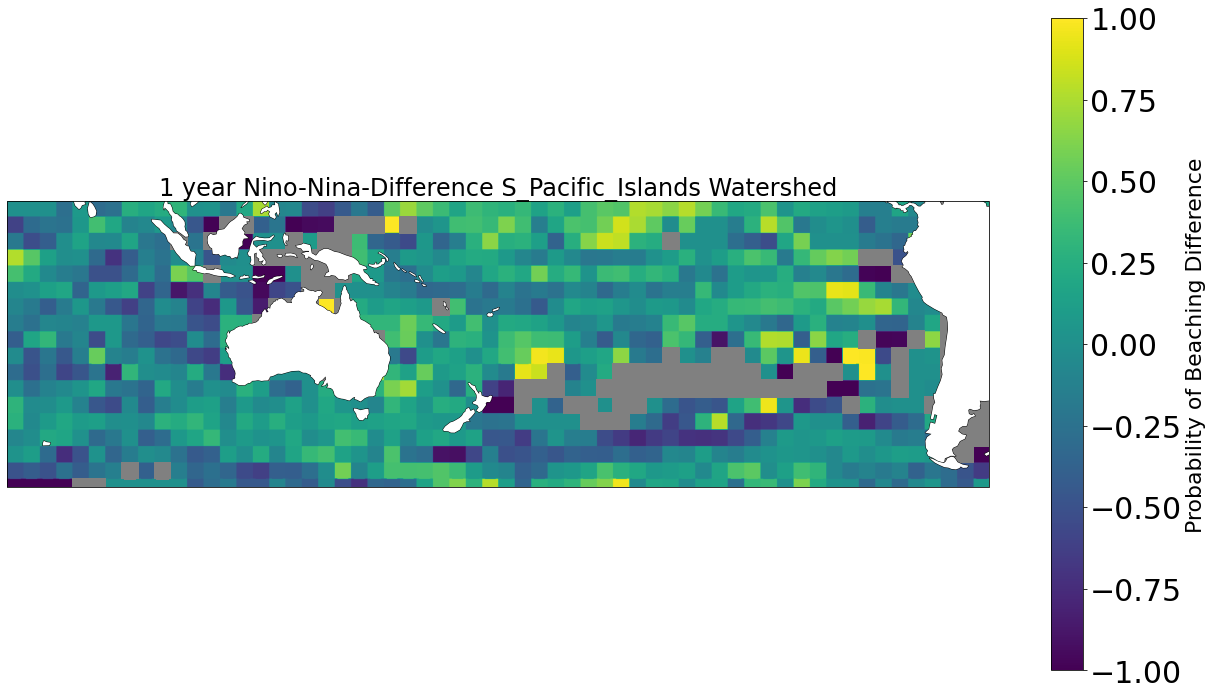

In [223]:
# S_Pacific_Islands 1 year
plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-180))
ax.set_extent([120, -120, -60, 10], crs=ccrs.PlateCarree(central_longitude=-180))

# colormap
cmap = plt.cm.get_cmap("viridis").copy()
cmap.set_bad('grey')

# plot hist on world
plt.imshow(difference_1_year, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap, transform = ccrs.PlateCarree())

# Load the world shapefile from GeoPandas
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
ax.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax.add_feature(land_feature)

plt.colorbar(label='Probability of Beaching Difference')
#ax.set_aspect('auto')
plt.title('1 year Nino-Nina-Difference S_Pacific_Islands Watershed')
plt.show()

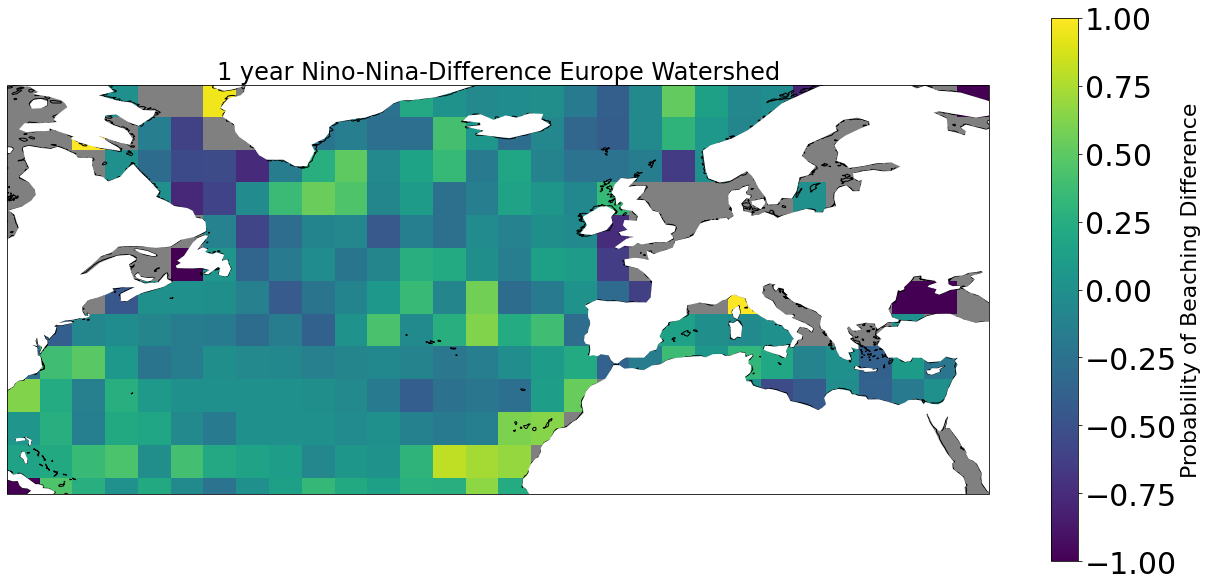

In [224]:
# Europe 1 year
plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(22, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-80, 40, 20, 70], crs=ccrs.PlateCarree())

# colormap
cmap = plt.cm.get_cmap("viridis").copy()
cmap.set_bad('grey')

# plot hist on world
plt.imshow(difference_1_year, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap, transform = ccrs.PlateCarree())

# Load the world shapefile from GeoPandas
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
ax.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax.add_feature(land_feature)

plt.colorbar(label='Probability of Beaching Difference')
#ax.set_aspect('auto')
plt.title('1 year Nino-Nina-Difference Europe Watershed')
plt.show()

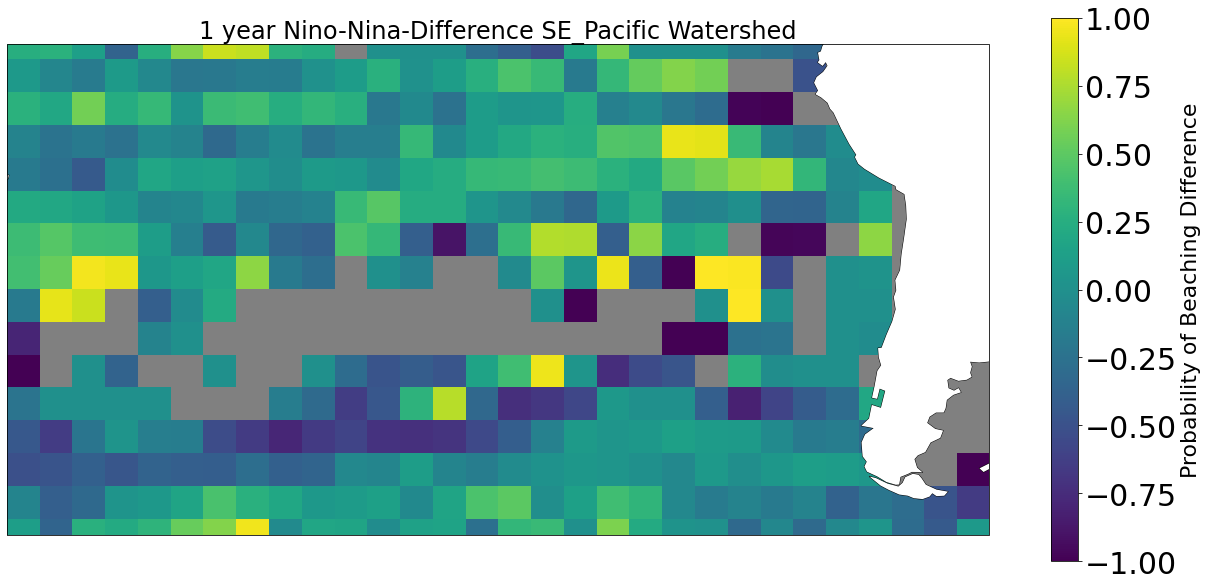

In [225]:
# SE_Pacific 1 year
plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(22, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, -60, -60, 0], crs=ccrs.PlateCarree())

# colormap
cmap = plt.cm.get_cmap("viridis").copy()
cmap.set_bad('grey')

# plot hist on world
plt.imshow(difference_1_year, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap, transform = ccrs.PlateCarree())

# Load the world shapefile from GeoPandas
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
ax.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax.add_feature(land_feature)

plt.colorbar(label='Probability of Beaching Difference')
#ax.set_aspect('auto')
plt.title('1 year Nino-Nina-Difference SE_Pacific Watershed')
plt.show()